In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
import seaborn as sns
import random

c:\users\thomas\appdata\local\programs\python\python37\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from math import sqrt
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from statistics import mode
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Toolbox

In [3]:
# Safe division

def safe_ratio(a,b):
    if a is None or b is None or b == 0:
        return None
    else:
        return float(a) / float(b)

# Stats columns

def test_integer(x):
    try:
        int(x)
        return True
    except:
        return False

def find_first_non_null_value(s):
    return s.loc[~s.isnull()].iloc[0]

def stat_column(df, col, text_threshold, num_threshold):
    (nb_rows, nb_cols) = df.shape

    density = safe_ratio(df[col].count(),nb_rows)
    dtype = str(df[col].dtype)
    try:
        dist_value = df[col].nunique()
    except:
        dist_value = np.nan
    uniqueness = safe_ratio(dist_value,nb_rows)

    if dist_value == 2:
        inferred_type = 'binary'
    elif dist_value == 1:
        inferred_type = 'constant'
    elif dtype in ('datetime64[ns]'):
        inferred_type = 'datetime'
    elif dtype == 'object':
        if dist_value > num_threshold and test_integer(find_first_non_null_value(df[col])):
            inferred_type = 'numerical'
        elif dist_value > text_threshold:
            inferred_type = 'text'
        else:
            inferred_type = 'categorical'
    elif dtype in ('int64', 'int32', 'float64', 'float32'):
        if dist_value > num_threshold:
            inferred_type = 'numerical'
        else:
            inferred_type = 'categorical'
    else :
        inferred_type = '???'

    return {"column":col,"Density":density,"Type":dtype,"Distinct Values": dist_value,"Uniqueness":uniqueness,'Inferred Type':inferred_type}

# Info DataFrame

def info_df(df, text_threshold = 70, num_threshold = 7):
    (nb_rows, nb_cols) = df.shape

    cols = df.columns
    stats = [stat_column(df, col, text_threshold, num_threshold) for col in cols]
    stats_df = pd.DataFrame.from_dict(stats)
    stats_df.set_index("column",inplace=True,drop=True)
    stats_df = stats_df.sort_values(['Inferred Type','Uniqueness','Density'])

    return (nb_rows, nb_cols, stats_df)

In [4]:
print(sys.version)

3.7.0 (v3.7.0:1bf9cc5093, Jun 27 2018, 04:59:51) [MSC v.1914 64 bit (AMD64)]


## Import Ratings

In [5]:
# ratings
ratings = pd.read_csv('data/ratings.csv', dtype = {'userId' : 'str', 'movieId' : 'str'})
ratings['timestamp'] = pd.to_datetime(ratings["timestamp"], unit='s')

# eval_ratings
eval_ratings = pd.read_csv('data/evaluation_ratings.csv', dtype = { 'userId' : 'str', 'movieId' : 'str'})

target = 'rating'

# Data Analysis

In [6]:
## Info Ratings

nratings, ncols, info_ratings = info_df(ratings)
nmovies = ratings['movieId'].nunique()
nusers = ratings['userId'].nunique()
start_rating = ratings['timestamp'].min()
end_rating = ratings['timestamp'].max()

print("rating counts : %d" % nratings)
print("movie counts : %d" % nmovies)
print("user counts : %d" % nusers)
print("ratings from %s to %s" % (start_rating, end_rating))

info_ratings.head(10)

rating counts : 20824175
movie counts : 43331
user counts : 270896
ratings from 1995-01-09 11:46:49 to 2017-08-04 06:57:50


,Density,Distinct Values,Inferred Type,Type,Uniqueness
column,,,,,
timestamp,1.0,16906629,datetime,datetime64[ns],8.118751e-01
rating,1.0,10,numerical,float64,4.802111e-07
movieId,1.0,43331,numerical,object,2.080803e-03
userId,1.0,270896,numerical,object,1.300873e-02


We have more than 20 millions ratings from 208K users about 43K movies. That's a lot of data, we will have to sample if we want ours algorithms to work on a single machine.

In [7]:
## Users Ratings

users = ratings.groupby('userId')['rating'].agg(['count','mean','sum','min','max','std'])

quantiles = [0.01,0.1,0.25,0.5,0.75,0.9,0.99]

users.describe(quantiles)

,count,mean,sum,min,max,std
count,270896.000000,270896.000000,270896.000000,270896.000000,270896.000000,265812.000000
mean,76.871475,3.620506,271.214326,1.661508,4.831636,0.936191
std,164.569618,0.587283,546.673672,1.065634,0.453159,0.326940
min,1.000000,0.500000,0.500000,0.500000,0.500000,0.000000
1%,1.000000,1.857036,4.000000,0.500000,3.000000,0.000000
10%,5.000000,2.928571,19.000000,0.500000,4.000000,0.567099
25%,12.000000,3.307692,40.000000,1.000000,5.000000,0.731289
50%,24.000000,3.660538,88.500000,1.000000,5.000000,0.914632
75%,74.000000,4.000000,272.500000,2.500000,5.000000,1.124988
90%,189.000000,4.291667,682.500000,3.000000,5.000000,1.348076


Some of the users didn't do a lot of ratings (only one or two for example). It's going to be difficult to give a prediction for these people without any further informations. Besides some of the users have done more than 10K ratings (robots ?). They are more likely going to noise the model so we will remove them from our study.

In [8]:
## Movies Ratings

movies_ratings = ratings.groupby('movieId')['rating'].agg(['count','mean','sum','min','max','std'])

movies_ratings.describe(quantiles)

,count,mean,sum,min,max,std
count,43331.000000,43331.000000,43331.000000,43331.000000,43331.000000,35265.000000
mean,480.583762,3.070312,1695.573054,1.571369,4.152651,0.958400
std,2478.066329,0.743259,9379.195741,1.223402,1.042989,0.403927
min,1.000000,0.500000,0.500000,0.500000,0.500000,0.000000
1%,1.000000,0.500000,0.500000,0.500000,0.500000,0.000000
10%,1.000000,2.053546,3.000000,0.500000,3.000000,0.408248
25%,2.000000,2.700000,6.000000,0.500000,3.500000,0.763763
50%,7.000000,3.166667,22.000000,1.000000,4.500000,0.967375
75%,62.000000,3.525000,195.500000,2.500000,5.000000,1.137348
90%,604.000000,3.875000,1929.000000,3.500000,5.000000,1.414214


Some of the movies don't have a lot of ratings. It's going to be difficult to give a prediction for these movies without any further informations. Thanksfully in the dataset movies_metadata we have some informations about the movies themselves that can be used for the predictions.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

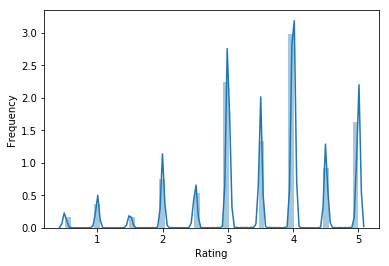

In [9]:
## Distribution target

fig = sns.distplot(ratings[target])
fig.set_xlabel('Rating',fontsize=10)
fig.set_ylabel("Frequency",fontsize=10)

Most of the ratings are between 3 and 5, people rate mostly the movies they enjoy. It can be a problem because we don't know if no critic means that the user didn't like the movie or he just didn't rate it.

In [10]:
## Info Eval Ratings

neval_ratings, ncols, info_eval_ratings = info_df(eval_ratings)
nmovies = eval_ratings['movieId'].nunique()
nusers = eval_ratings['userId'].nunique()

print("rating counts : %d" % neval_ratings)
print("movie counts : %d" % nmovies)
print("user counts : %d" % nusers)

info_eval_ratings.head(10)

rating counts : 5198034
movie counts : 29866
user counts : 262202


,Density,Distinct Values,Inferred Type,Type,Uniqueness
column,,,,,
movieId,1.0,29866,numerical,object,0.005746
userId,1.0,262202,numerical,object,0.050443


We have 5 millions ratings from 262K users about 30K movies.

# Sampling

We are going to focus only on the users who has done the most ratings, the most popular movies and remove the outliers to reduce the number of samples.

In [11]:
## Sample ratings

# Select top movies
topn_movies = 10000
top_movies = list(movies_ratings.sort_values('sum', ascending = False).head(topn_movies).index)

# Select top users
topn_users = 50000
top_users = list(users.sort_values('count', ascending = False).head(topn_users).index)

# Remove outlier
outliers = users.query("count > 10000").index
top_users = [x for x in top_users if x not in outliers]

sample_ratings = ratings[ratings['userId'].isin(top_users)]
sample_ratings = sample_ratings[sample_ratings['movieId'].isin(top_movies)]
nsamples = len(sample_ratings)
print("sample ratings count : %d, %0.2f pct of ratings" % (nsamples, 100*safe_ratio(nsamples, nratings)))

sample_eval_ratings = eval_ratings[eval_ratings['userId'].isin(top_users)]
sample_eval_ratings = sample_eval_ratings[sample_eval_ratings['movieId'].isin(top_movies)]
nsamples = len(sample_eval_ratings)
print("sample eval ratings count : %d, %0.2f pct of eval ratings" % (nsamples, 100*safe_ratio(nsamples, neval_ratings)))

sample ratings count : 14447753, 69.38 pct of ratings
sample eval ratings count : 3611329, 69.47 pct of eval ratings


# Sampling

In order to test ours models we operate a stratify split on sample_ratings. All the movies and users in test are also in train. We made the hypothesis that the timestamp don't have any influence on the users' tastes, which is a strong hypothesis (the tastes of a user can't change over the years).

In [12]:
## Split Train and Test

train, test = train_test_split(sample_ratings, stratify = sample_ratings["userId"], test_size=0.25, random_state = 42, shuffle = True)

# Remove ratings movies not in train
test = test[test['movieId'].isin(train['movieId'])]

print("Train set : %d ratings" % len(train))
print("Test set : %d ratings" % len(test))

Train set : 10835814 ratings
Test set : 3611939 ratings


# Data Modeling

## Most Popular

We are going to do a first quick model which return the average rating of the movie whatever the user. This simple model will be used as refence to compare with the performance of all the others models.

In [13]:
## First Quick Model : Average Rating

class MostPopularRecommender:
    
    def __init__(self, items_df):
        self.items_df = items_df
        
    def predict(self, eval_df):
        avg_items_rate = self.items_df[['mean']]
        avg_items_rate.columns = ['mp_pred']
        return pd.merge(eval_df, avg_items_rate, how = 'left', left_on = 'movieId', right_index = True)
        
    def recommend_items(self, userId = None, items_to_ignore=[], topn=10):
        recos = self.items_df[~self.items_df.index.isin(items_to_ignore)] \
                               .sort_values('sum', ascending = False) \
                               .head(topn)
        
        recos = recos[['mean']].reset_index().rename(columns={'mean': 'rating'})

        return recos

# Compute aggregates for each movie in train
train = train.sort_values('movieId')
test = test.sort_values('movieId')
movies_agg = train.groupby("movieId")['rating'].agg(['count','mean','sum'])

# Create MostPopular Model
popular_model = MostPopularRecommender(movies_agg)

# Predict
train = popular_model.predict(train)
test = popular_model.predict(test)
train.head()

,userId,movieId,rating,timestamp,mp_pred
14591711,189145,1,4.0,2001-10-22 12:23:01,3.861748
5431605,70040,1,4.0,2000-08-10 04:07:04,3.861748
641132,8246,1,4.0,2011-03-30 03:50:00,3.861748
17634963,228858,1,1.0,2015-11-13 11:50:13,3.861748
15345967,199157,1,3.0,2006-12-01 01:13:33,3.861748


In [14]:
## Most Popular Movies

popular_model.recommend_items(topn=5)

,movieId,rating
0,296,4.213646
1,2571,4.147149
2,318,4.390257
3,356,3.950727
4,260,4.142870


In [15]:
## Evaluate Model

rmse = sqrt(mean_squared_error(train['rating'], train['mp_pred']))
print("train :")
print("rmse : %0.3f" % rmse)
print()

rmse = sqrt(mean_squared_error(test['rating'], test['mp_pred']))
print("test :")
print("rmse : %0.3f" % rmse)

train :
rmse : 0.939

test :
rmse : 0.939


We obtain with this technique a RMSE of 0.939 which is not so bad for a first model.

## Collaborative Filtering

We are going to do a second model based on Collaborative Filtering. Theses methods don't use features about the users or the movies themselves to make the predictions. They follow the principle "if user A likes movies X, Y, Z and user B likes movies X, Y, user B is likely to like movie Z". There are various methods to do Collaborative Filtering : KNNeighbours, Matrix Factorization, Multi-layered Neural Net. We are going to use a Matrix Factorization method with the algorithm SVD.

In [16]:
## Second Model : Collaborative Filtering

class CollaborativeFilteringRecommender:
    
    def __init__(self, users_items_pivot_df, nb_factors):
        # Creating a sparse pivot matrix with users in rows and movies in columns
        users_items_pivot_matrix = users_items_pivot_df.as_matrix()

        # Performs matrix factorization of the original user movie matrix
        U, sigma, Vt = svds(users_items_pivot_matrix, k = nb_factors)
        sigma = np.diag(sigma)

        preds_matrix = np.dot(np.dot(U, sigma), Vt)

        # Converting the reconstructed matrix back to a Pandas dataframe
        self.preds_df = pd.DataFrame(preds_matrix, columns = users_items_pivot_df.columns, index = users_items_pivot_df.index).transpose()

        
    def predict_rate(self, itemId, userId):
            return self.preds_df[userId][itemId]
        
    def predict(self, eval_df):
        if 'cf_pred' in eval_df.columns:
            eval_df = eval_df.drop(labels = 'cf_pred', axis = 1)
            
        sub_df = eval_df[eval_df['movieId'].isin(self.preds_df.index)]
        sub_df = sub_df[sub_df['userId'].isin(self.preds_df.columns)]
        sub_df['cf_pred'] = sub_df.apply(lambda df : self.predict_rate(itemId = df['movieId'], userId = df['userId']), axis = 1)
        
        return pd.merge(eval_df, sub_df[['cf_pred']], how = 'left', left_index  = True, right_index = True)
        
    def recommend_items(self, userId, items_to_ignore=[], topn=10):
        if userId in self.preds_df.columns:
            # Get all the predictions corresponding to the userId
            sorted_user_predictions = self.preds_df[userId].sort_values(ascending=False) \
                                        .reset_index().rename(columns={userId: 'rating'})

            # Sort the ratings and return the topn
            recos = sorted_user_predictions[~sorted_user_predictions['movieId'].isin(items_to_ignore)] \
                                   .sort_values('rating', ascending = False) \
                                   .head(topn)
        else:
            recos = pd.DataFrame(columns = ['movieId','rating'])
            
        return recos

# Pivot
users_movies_pivot_df = train.pivot(index='userId', columns='movieId', values='rating').fillna(train['rating'].median())

# The number of factors to factor the user-movie matrix.
nb_factors = 70

# Build CF model
cf_model = CollaborativeFilteringRecommender(users_movies_pivot_df, nb_factors)

cf_model.preds_df.head()

userId,100002,100004,100008,10002,100021,100022,100037,100038,100046,100048,...,9996,99965,9997,99971,99973,99983,99984,99992,99994,99996
movieId,,,,,,,,,,,,,,,,,,,,,
1,3.522884,3.977115,4.201400,3.598936,3.507764,3.892707,3.689926,2.789127,3.250557,3.730536,...,3.716617,3.509158,3.365332,3.680006,1.942607,3.820439,3.029343,3.722837,3.848893,3.672902
10,3.494999,3.509620,3.527488,3.197652,3.847030,3.663810,3.437453,3.138557,3.409887,3.191700,...,3.480357,3.451854,3.674326,3.439993,3.459818,3.568722,3.480288,3.593913,3.489629,3.506264
100,3.510252,3.489610,3.482363,3.469455,3.415586,3.477706,3.508203,3.490496,3.467005,3.501384,...,3.496014,3.485515,3.485404,3.470693,3.485929,3.505731,3.476251,3.499609,3.492257,3.507933
1000,3.499248,3.503367,3.496796,3.495954,3.444784,3.501956,3.501260,3.517793,3.496646,3.508844,...,3.497204,3.504867,3.499954,3.490414,3.493426,3.498527,3.507489,3.501683,3.510033,3.501033
100044,3.508897,3.497239,3.493902,3.509437,3.501855,3.498804,3.504650,3.443158,3.504888,3.483805,...,3.506292,3.497110,3.495610,3.499670,3.512224,3.503921,3.485397,3.492961,3.490315,3.502563


In [17]:
## Get recommendations for user 100021

# movies that user 100021 has already seen
items_to_ignore = list(train[train['userId'] == '100021']['movieId'])

cf_model.recommend_items('100021', items_to_ignore)

,movieId,rating
14,7153,4.515077
17,6,4.319810
18,1387,4.313211
22,912,4.250707
23,1617,4.247667
28,2000,4.217393
31,377,4.156260
32,1090,4.149224
33,3421,4.133269
37,1704,4.093634


In [18]:
## Evaluate CF Model

test = cf_model.predict(test)
rmse = sqrt(mean_squared_error(test['rating'], test['cf_pred']))

print("rmse : %0.3f" % rmse)

rmse : 0.959


The RMSE is greather than the first model. We could improve the performance of the model by looking for the best number of factors which minimizes the RMSE using cross-validation and a gridsearch.


## Content-Based

We are now going to take a content-based approach. These models used features about the movies themselves to make the predictions.

In [19]:
## Import Movies

movies = pd.read_csv('data/movies_metadata.csv', dtype = {'id':'str'})
movies = movies[~movies.index.isin([35587,19730, 29503])] # malformed rows
movies = movies.drop_duplicates('id')
movies = movies.set_index('id')

movies['release_date'] = pd.to_datetime(movies["release_date"], format="%Y-%m-%d")
movies['year'] = movies.apply(lambda df : df['release_date'].year, axis = 1)

for item in ['popularity','revenue']:
    movies[item] = movies[item].astype('float64')
    
movies.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
id,,,,,,,,,,,,,,,,,,,,,
862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995.0
8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0
15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995.0
31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995.0
11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995.0


The dataset movies_metadata contains a lot of JSON columns. We are going to extract them for our study.

In [20]:
## Extract JSON columns

array_json_columns = ['genres', 'production_companies','production_countries','spoken_languages']

def extract_array_json(json):
    if pd.isna(json):
        return ""
    else:
        d = eval(json)
        d = [x.get('name') for x in d]
        return ' '.join(d)
    
def extract_json(json):
    if pd.isna(json):
        return ""
    else:
        d = eval(json)
        return d.get('name')

# Convert to python dict
for column in array_json_columns:
    movies[column] = movies.apply(lambda df : extract_array_json(df[column]), axis = 1)
    print('%s has been parsed' % column)

movies['belongs_to_collection'] = movies.apply(lambda df : extract_json(df['belongs_to_collection']), axis = 1)
print('belongs_to_collection has been parsed')
movies[array_json_columns].head()

genres has been parsed
production_companies has been parsed
production_countries has been parsed
spoken_languages has been parsed
belongs_to_collection has been parsed


,genres,production_companies,production_countries,spoken_languages
id,,,,
862,Animation Comedy Family,Pixar Animation Studios,United States of America,English
8844,Adventure Fantasy Family,TriStar Pictures Teitler Film Interscope Commu...,United States of America,English Français
15602,Romance Comedy,Warner Bros. Lancaster Gate,United States of America,English
31357,Comedy Drama Romance,Twentieth Century Fox Film Corporation,United States of America,English
11862,Comedy,Sandollar Productions Touchstone Pictures,United States of America,English


In [21]:
## Info Movies

nrows, ncols, info_movies = info_df(movies)

print("row counts : %d" % nrows)
print("column counts : %d" % ncols)

nratings_metadata = len(ratings[ratings['movieId'].isin(movies.index)])
print("%d of ratings in 'ratings' have metadata (%0.2f pct)" % (nratings_metadata, 100 * safe_ratio(nratings_metadata, nratings)))

neval_ratings_metadata = len(eval_ratings[eval_ratings['movieId'].isin(movies.index)])
print("%d of ratings in 'eval_ratings' have metadata (%0.2f pct)" % (neval_ratings_metadata, 100 * safe_ratio(neval_ratings_metadata, neval_ratings)))

info_movies = info_movies.sort_values('Density', ascending = False)

info_movies.head(30)

row counts : 45433
column counts : 24
9152074 of ratings in 'ratings' have metadata (43.95 pct)
2284329 of ratings in 'eval_ratings' have metadata (43.95 pct)


,Density,Distinct Values,Inferred Type,Type,Uniqueness
column,,,,,
belongs_to_collection,1.000000,1696,text,object,0.037330
original_title,1.000000,43371,text,object,0.954614
production_companies,1.000000,22672,text,object,0.499021
genres,1.000000,4066,text,object,0.089494
production_countries,1.000000,2390,text,object,0.052605
budget,1.000000,1223,numerical,object,0.026919
spoken_languages,1.000000,1842,text,object,0.040543
adult,1.000000,2,binary,object,0.000044
popularity,0.999934,43848,numerical,float64,0.965113


We have a list of 45K movies with metadata, unfortunately only 43% of the ratings have metadata.

In [22]:
## Fill Data
    
# All columns where missing values can be replaced with the median
for col in ['runtime', 'year', 'revenue', 'vote_count', 'vote_average', 'popularity']:
    movies[col] = movies[col].fillna(movies[col].median())
    
# All columns where missing values can be replaced with the mode (most frequently occurring value)
for col in ['status','video', 'original_language']:
    movies[col] = movies[col].fillna(movies[col].mode()[0])
    
# All columns whe missing values can be replaces by empty string
for col in ['tagline','overview','title']:
    movies[col] = movies[col].fillna("")
        
nrows, ncols, info_movies = info_df(movies)

info_movies.head(30)

,Density,Distinct Values,Inferred Type,Type,Uniqueness
column,,,,,
adult,1.000000,2,binary,object,0.000044
video,1.000000,2,binary,bool,0.000044
status,1.000000,6,categorical,object,0.000132
release_date,0.998085,17333,datetime,datetime64[ns],0.381507
vote_average,1.000000,92,numerical,float64,0.002025
year,1.000000,135,numerical,float64,0.002971
runtime,1.000000,353,numerical,float64,0.007770
budget,1.000000,1223,numerical,object,0.026919
vote_count,1.000000,1820,numerical,float64,0.040059


Content-based models used similarities between the movies to make the predictions. That is why we need to vectorize ours movies. For that purpose we are going to operate a TFidfVectorizer on a column 'text' which is a mixed of all informations we have about the movies (genre, tagline, collection, overview, title...).

In [23]:
## Combine columns to create a feature text

def combine_string_columns(col1, col2):
    return movies[col1] + ' ' + movies[col2]

movies['text'] = movies['title']

for col in array_json_columns + ['overview','original_title','title','tagline','belongs_to_collection','original_language','status']:
    movies['text'] = combine_string_columns('text', col)

In [24]:
## TFIDF Vectorizer

# Ignoring stopwords english, french, italian, spanish (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('french') + stopwords.words('italian') + stopwords.words('spanish')

# Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
params = {
    'analyzer' : 'word',
    'ngram_range' : (1,3),
    'lowercase' : True,
    'token_pattern' : '(?u)\\b\\w+\\b',
    'ngram_range' : (1, 3),
    'min_df' : 0.003,
    'max_df' : 0.5,
    'max_features' : 5000,
    'stop_words' : stopwords_list
}

vectorizer = TfidfVectorizer(**params)

movie_ids = movies.index.tolist()
tfidf_matrix = vectorizer.fit_transform(movies['text'])
voc = vectorizer.get_feature_names()

tfidf_matrix

<45433x2614 sparse matrix of type '<class 'numpy.float64'>'
	with 1471512 stored elements in Compressed Sparse Row format>

Text(0.5,1,'Word Frequencies')

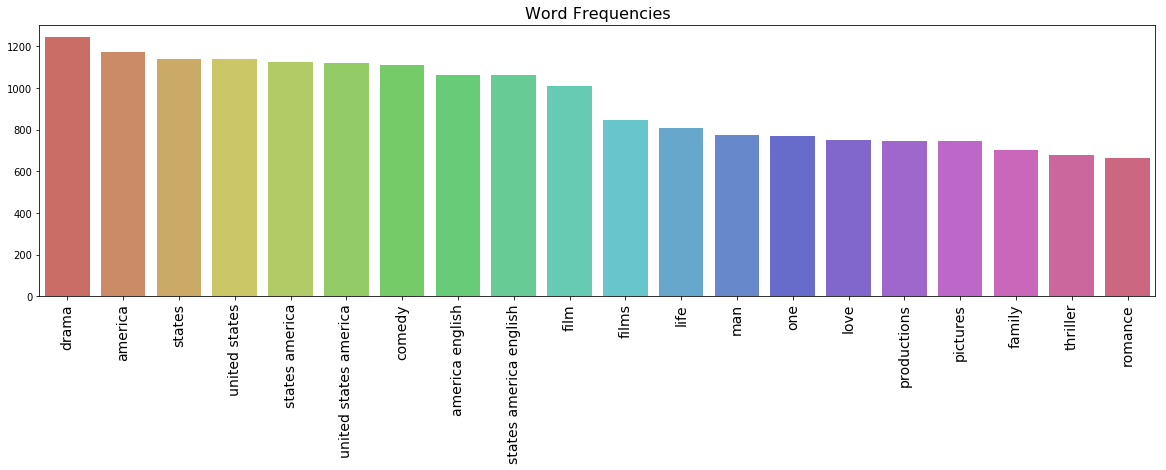

In [25]:
## Words Frequencies

n_top_words = 20

sum_words = tfidf_matrix.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for idx, word in enumerate(voc)]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq = pd.DataFrame(words_freq,columns = ['word','count']).set_index("word")

fig, ax = plt.subplots(1,1,figsize=(20,5))

sns.barplot(list(range(n_top_words)), words_freq['count'].values[:n_top_words], palette='hls', ax=ax)

ax.set_xticks(list(range(n_top_words)))
ax.set_xticklabels(words_freq.index[:n_top_words], fontsize=14, rotation=90)
ax.set_title("Word Frequencies", fontsize=16)

We can know make our model. To predict an unknown pair of user/movie the model is going to see if the user had rated similar movies (using the cosinus between the movies vectors) and take the mean.

In [26]:
## Third Model : Content-Based

class ContentBasedRecommender:
    
    def __init__(self, item_profiles, item_ids, ratings):
        self.item_profiles = item_profiles
        self.item_ids = item_ids
        ratings['id'] = ratings.apply(lambda df: df['userId'] + "_" + df['movieId'], axis = 1)
        self.ratings = ratings
        
    def get_item_profile(self, itemId):
        if itemId in self.item_ids:
            idx = self.item_ids.index(itemId)
            return self.item_profiles[idx:idx+1]
        else:
            return None
    
    def get_items_subset_profiles(self, items_subset):
        item_ids = [x for x in items_subset if x in self.item_ids]
        indices = [self.item_ids.index(x) for x in item_ids]
        return  self.item_profiles[indices]
    
    def similarity(self, item1, item2):
        profile1 = self.get_item_profile(item1)
        profile2 = self.get_item_profile(item2)
        return cosine_similarity(profile1, profile2)[0][0]
    
    def get_similar_items(self, itemId, threshold, topn=10):
        # Get item profile
        item_profile = self.get_item_profile(itemId)
        
        if item_profile is not None:

            # Computes the cosine similarity between the item profile and all the item profiles
            cosine_similarities = cosine_similarity(item_profile, self.item_profiles)

            # Gets the top similar items
            similar_indices = cosine_similarities.argsort().flatten()[-topn:]

            # Sort the similar items by similarity
            similar_items = sorted([(self.item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
            similar_items = pd.DataFrame(similar_items, columns = ['movieId','cos'])
            
            # Filter non similar items using the threshold
            similar_items = similar_items[similar_items['cos'] >= threshold]

            return similar_items
        
        else:
            return pd.DataFrame(columns = ['movieId','cos'])
        
    def predict(self, eval_df, threshold = 0.5):
        # Filter movies with metadata
        eval_df['id'] = eval_df.apply(lambda df: df['userId'] + "_" + df['movieId'], axis = 1)
        eval_metadata = eval_df[eval_df["movieId"].isin(self.item_ids)]
        
        # Get items with ratings
        eval_item_ids = list(eval_metadata['movieId'].unique())
        train_item_ids = list(self.ratings['movieId'].unique())

        # Get items profiles
        eval_item_profiles = self.get_items_subset_profiles(eval_item_ids)
        train_item_profiles = self.get_items_subset_profiles(train_item_ids)

        # Calcule similarity between items, filter if similarity is lower than threshold
        cosine_similarities = cosine_similarity(eval_item_profiles, train_item_profiles)

        eval_items = []
        train_items = []
        cos = []

        for i, eval_item in enumerate(eval_item_ids):
            for j, train_item in enumerate(train_item_ids):
                if eval_item != train_item and cosine_similarities[i][j] > threshold:
                    eval_items.append(eval_item)
                    train_items.append(train_item)
                    cos.append(cosine_similarities[i][j])

        similarities = pd.DataFrame({"eval_items" : eval_items, 'train_items' : train_items,'cosinus':cos})
        
        # Enrich eval_df with similar items
        enriched_eval = pd.merge(eval_metadata[['movieId','userId','id']], similarities, left_on = 'movieId', right_on = 'eval_items')
        enriched_eval['tmp_id'] = enriched_eval.apply(lambda df: df['userId'] + "_" + df['train_items'], axis = 1)
        
        # Used similar items to matches other ratings in 'ratings'
        matches = pd.merge(enriched_eval, self.ratings[['id','rating']], left_on = 'tmp_id', right_on = 'id')
        
        # Take the mean of these ratings to predict the rating
        predicted_eval = matches.groupby('id_x')['rating'].mean().reset_index()[['id_x','rating']]
        predicted_eval.columns = ['id','cb_pred']

        return pd.merge(eval_df, predicted_eval, left_on = 'id', right_on = 'id', how = 'left')
        
        
    def recommend_items(self, userId, items_to_ignore=[], topn=10, threshold = 0.0):
        # Check if user has rated movies with metadata
        ratings = self.ratings[self.ratings['userId'] == userId]
        
        if len(ratings) > 0:
            # Favourite item of userId
            prefer_item = ratings.sort_values('rating', ascending=False)['movieId'].iloc[0]
            
            # Get topn similar items among all not ignored items
            similar_items = self.get_similar_items(itemId = prefer_item, topn = topn, threshold = threshold)
            
            return similar_items[~similar_items['movieId'].isin(items_to_ignore)]
        else:
            return pd.DataFrame(columns = ['movieId','cos'])

train_metadata = train[train['movieId'].isin(movie_ids)]

cb_model = ContentBasedRecommender(tfidf_matrix, movie_ids, train_metadata)

# Get recommendations for user 100021
items_to_ignore = list(train_metadata[train_metadata['userId'] == '100021']['movieId'])
cb_model.recommend_items('100021', items_to_ignore = items_to_ignore)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,movieId,cos
1,3597,0.584836
2,3600,0.504492
3,3602,0.461310
4,389854,0.425611
5,72002,0.424303
6,268015,0.411104
7,299309,0.399655
8,113784,0.398353
9,27824,0.392089


In [27]:
## Check Similarity between two movies

cb_model.similarity('541','17897')

0.4748780578624992

In [50]:
## Evaluate Model

test = cb_model.predict(test, 0.65)
sub_test = test[pd.isna(test['cb_pred']) == False]

rmse = sqrt(mean_squared_error(sub_test['rating'], sub_test['cb_pred']))

print("rmse : %0.3f" % rmse)

rmse : 1.203


The RMSE is greather than before. We should optimize the tfidf_vectorizer to minimize the RMSE by adding stop_words, using stemming ...

In [51]:
## Train on all the data

# Most Popular
popular_model = MostPopularRecommender(movies_ratings)

In [52]:
## Predict on eval_ratings

# Avg movie ratings
eval_ratings = popular_model.predict(eval_ratings)

# Collaborative Filtering
eval_ratings = cf_model.predict(eval_ratings)

# Content-Based 
eval_ratings = cb_model.predict(eval_ratings, 0.5)

# Predict ratings
def coalesce(*arg):
  for el in arg:
    if el is not None and pd.isna(el) == False:
      return el
  return None

eval_ratings ['rating'] = eval_ratings.apply(lambda df : coalesce(df["cf_pred"], df["cb_pred"], df["mp_pred"]), axis = 1)

In [53]:
## Info Eval Ratings

_, _ , info_eval_ratings = info_df(eval_ratings)

info_eval_ratings.head(10)

,Density,Distinct Values,Inferred Type,Type,Uniqueness
column,,,,,
cb_pred,0.003945,38,numerical,float64,0.000007
mp_pred,1.000000,11770,numerical,float64,0.002264
movieId,1.000000,29866,numerical,object,0.005746
userId,1.000000,262202,numerical,object,0.050443
cf_pred,0.694749,3611329,numerical,float64,0.694749
rating,1.000000,3622913,numerical,float64,0.696978
id,1.000000,5198034,numerical,object,1.000000


In [54]:
eval_ratings[['userId','movieId','rating']].to_csv('data/output.csv', sep=',', index=False)

## Avenues for improvement

- find the optimal number of factors of the collaborative filtering model.
- improve the preprocessing of the tfidf_vectorizer.
- find more metadata about the movies.
- use the different results of the models as features of a stacking model (ElasticNet, RandomForestRegressor...).
- because of the volume of data it is better to use the implementation of Alternative Least Squre by Spark on a Hadoop Cluster.